In [1]:
# Configuration

path_load = rf"C:\Users\Keon Oh LEE\Desktop\Research Notes\250915 보험\StateSpace_toy\sample_loss_ratio.csv"


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
# %matplotlib qt

import statsmodels.api as sm # State Space Model을 위한 라이브러리


In [3]:
# Load the sample data
df_raw = pd.read_csv(path_load)

# Process into runoff triangle
df = df_raw[['인수년월', '마감년월', '발생손해액']].copy()
df.columns = ['accident_ym', 'closing_ym', 'incurred_loss']
df['accident_ym'] = pd.to_datetime(df['accident_ym'], format='%Y%m', errors='coerce')
df['closing_ym'] = pd.to_datetime(df['closing_ym'], format='%Y%m', errors='coerce')

df

,accident_ym,closing_ym,incurred_loss
0,2021-01-01,2021-08-01,0
1,2021-01-01,2021-09-01,0
2,2021-01-01,2021-06-01,0
3,2021-01-01,2021-08-01,0
4,2021-01-01,2021-07-01,0
...,...,...,...
836,2021-01-01,2024-10-01,0
837,2021-01-01,2024-08-01,0
838,2021-01-01,2024-10-01,0
839,2021-01-01,2025-03-01,0


### Hoerl Curve model

$$
y(x) = \alpha \cdot x^{\beta} \cdot e^{-\gamma x}
$$

In [4]:
# 1.1 시뮬레이션 파라미터 설정
hoerl_alpha = 1000
hoerl_beta = 1.2
hoerl_gamma = 0.4

num_accident_years = 20
num_dev_periods = 20
initial_volume = 500000

volume_growth_rate = 0.04
noise_std_dev = 0.12

# 1.2 Hoerl Curve 함수 정의
def hoerl_curve(dev_period, alpha, beta, gamma):
    return alpha * ((dev_period + 1) ** beta) * np.exp(-gamma * (dev_period + 1))

# 1.3 지급 패턴 및 사고년도별 총 손해액 생성
dev_periods = np.arange(num_dev_periods)
dev_pattern_raw = hoerl_curve(dev_periods, hoerl_alpha, hoerl_beta, hoerl_gamma)
dev_pattern_normalized = dev_pattern_raw / np.sum(dev_pattern_raw)
accident_years_range = np.arange(num_accident_years)
accident_year_volumes = initial_volume * (1 + volume_growth_rate) ** accident_years_range

# 1.4 Runoff Triangle 생성 및 마스킹
perfect_triangle = np.zeros((num_accident_years, num_dev_periods))
for i in range(num_accident_years):
    perfect_triangle[i, :] = accident_year_volumes[i] * dev_pattern_normalized

noise_factor = np.exp(np.random.normal(loc=0, scale=noise_std_dev, size=perfect_triangle.shape))
final_triangle_values = perfect_triangle * noise_factor

runoff_triangle = pd.DataFrame(
    final_triangle_values,
    index=pd.RangeIndex(start=2005, stop=2005 + num_accident_years, name='accident_year'),
    columns=pd.RangeIndex(start=0, stop=num_dev_periods, name='development_period')
)

for i in range(num_accident_years):
    for j in range(num_dev_periods):
        if i + j >= num_accident_years -1: # 마지막 대각선부터 NaN 처리
            runoff_triangle.iloc[i, j] = np.nan

display(runoff_triangle.style.format(precision=0, na_rep=''))


development_period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
accident_year,,,,,,,,,,,,,,,,,,,,
2005,39079,65534,52121,61880,49148,43419,33819,31320,24186,19402,13564,10874,6154,5101,3155,2699,2343,1211,926,
2006,43824,60940,83199,61981,72382,50825,46776,31818,24173,20703,12063,12787,7229,4554,4069,3052,2405,1617,,
2007,46538,75669,55474,89081,58951,61970,45505,31631,25889,18832,10838,10367,10247,6115,4098,2921,2110,,,
2008,40957,76843,82702,64078,60743,54677,39408,38231,23715,21678,18241,10582,8692,6756,3665,3243,,,,
2009,50341,65619,81050,63170,84928,66834,53475,35874,27165,20169,18368,10986,8109,6510,3811,,,,,
2010,42250,68753,93576,76662,81507,61239,43594,35292,32001,18553,16939,13396,7501,5834,,,,,,
2011,51564,80443,89261,87825,92612,58027,51360,39386,35232,23891,17641,10597,8458,,,,,,,
2012,43202,68611,102852,98881,82815,58782,43149,36846,29281,18715,17530,15170,,,,,,,,
2013,41919,88745,88553,90574,84906,50068,45893,42372,34955,19780,19023,,,,,,,,,


In [5]:
# --- Part 2: Row-Wise Stacking 수행 ---

# stack() 메소드를 사용하여 각 행을 순서대로 쌓습니다.
# dropna=False 파라미터가 매우 중요합니다.
# 이 파라미터는 예측해야 할 미래 데이터인 NaN 값을 유지시켜 줍니다.
stacked_series = runoff_triangle.stack(dropna=False)

# 보기 좋고 다루기 쉽게, 간단한 정수 인덱스로 변환합니다.
# 이것이 최종적으로 모델에 입력될 1차원 시계열 데이터입니다.
time_series = stacked_series.reset_index(drop=True)
time_series.name = 'paid_amount'

print("생성된 시계열 데이터의 총 길이:", len(time_series))
print(time_series)


생성된 시계열 데이터의 총 길이: 400
0      39078.536843
1      65534.335301
2      52120.689617
3      61879.906548
4      49147.626596
           ...     
395             NaN
396             NaN
397             NaN
398             NaN
399             NaN
Name: paid_amount, Length: 400, dtype: float64


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_40124\4049038659.py:6: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  stacked_series = runoff_triangle.stack(dropna=False)


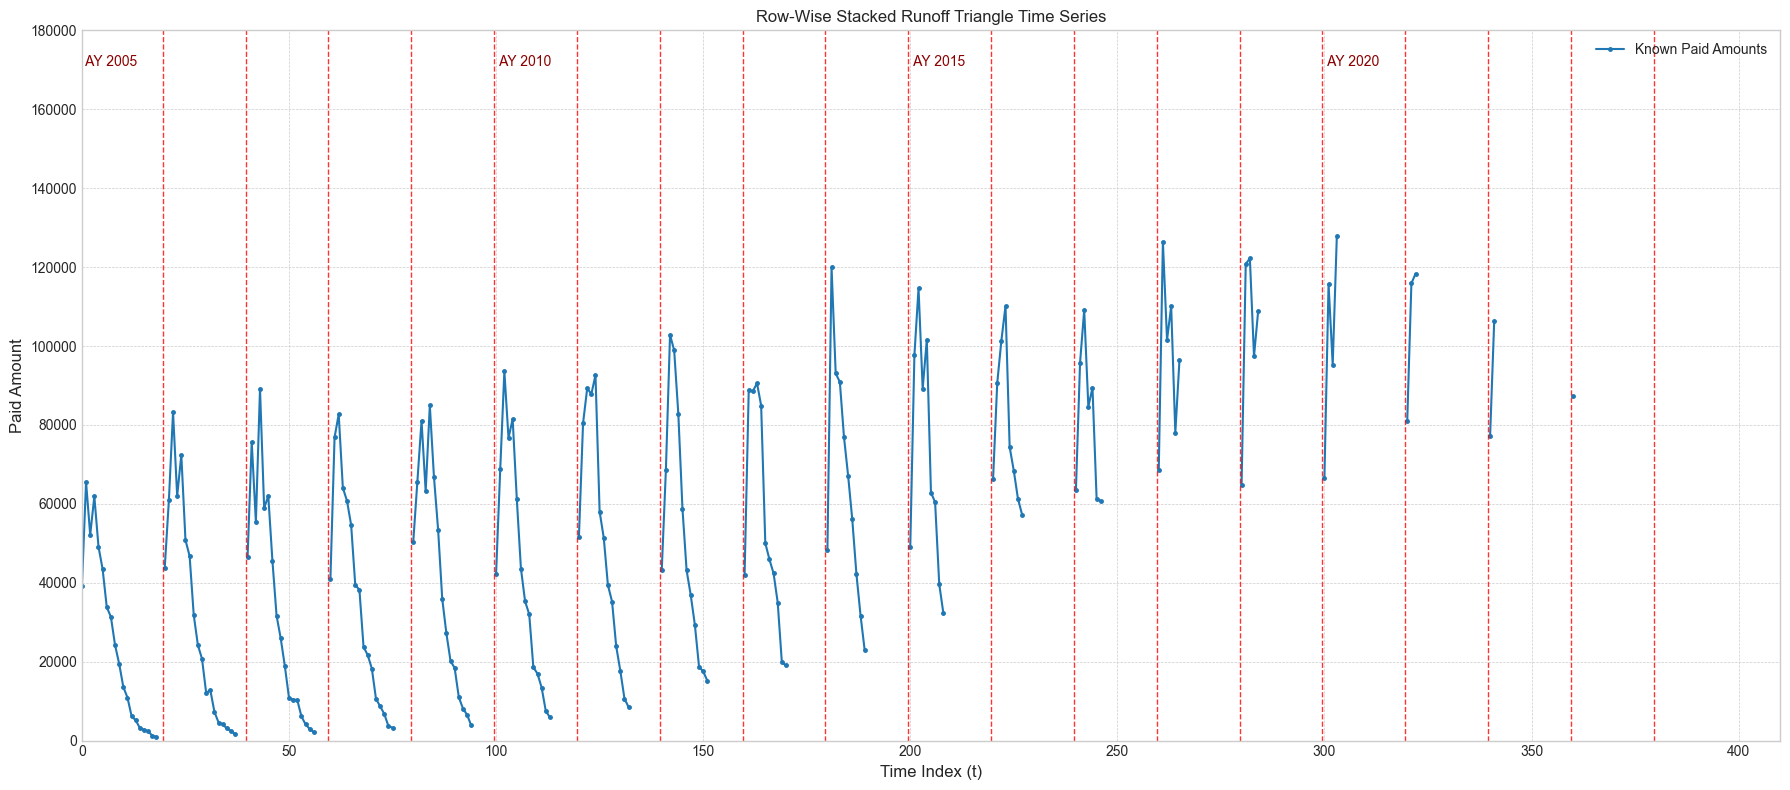

In [6]:
# --- Part 3: 결과 시각화 ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 8))

# 시계열 데이터 플롯
time_series.plot(ax=ax, marker='.', linestyle='-', markersize=5, label='Known Paid Amounts',
                 title='Row-Wise Stacked Runoff Triangle Time Series')

# 플롯 스타일링
ax.set_xlabel('Time Index (t)', fontsize=12)
ax.set_ylabel('Paid Amount', fontsize=12)
ax.set_xlim(0, 410)
ax.set_ylim(0, 180000)
ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# 각 사고년도가 시작되는 지점을 시각적으로 구분하기 위해 수직선 추가
for i in range(1, num_accident_years):
    ax.axvline(x=i * num_dev_periods - 0.5, color='red', linestyle='--', linewidth=1, alpha=0.8)

# 사고년도 텍스트 추가 (차트 가독성을 위해 5년 단위로)
for i in range(0, num_accident_years, 5):
    year_label = runoff_triangle.index[i]
    ax.text(i * num_dev_periods, ax.get_ylim()[1] * 0.95, f' AY {year_label}',
            color='darkred', fontsize=10)

plt.tight_layout()
plt.show()

In [7]:
# # level='local level': 레벨(추세)이 이전 시점의 값에 노이즈가 더해지는 랜덤 워크 형태임을 의미합니다.
# # seasonal=num_dev_periods: 주기가 20년(runoff_triangle의 열 개수)인 계절성 요소를 추가합니다.
# #                          이것이 'Column Effect'를 포착하는 핵심 부분입니다.
# model = sm.tsa.UnobservedComponents(
#     time_series,
#     level='local level',
#     seasonal=num_dev_periods
# )

# # statsmodels가 내부적으로 칼만 필터를 사용하여 최적의 파라미터를 찾습니다.
# # disp=False 옵션은 학습 과정을 화면에 출력하지 않도록 합니다.
# results = model.fit(disp=False)

# # 모델의 적합 결과를 요약해서 출력합니다.
# # Log-Likelihood, AIC/BIC 같은 통계치와 추정된 분산(sigma2) 값들을 확인할 수 있습니다.
# print(results.summary())


In [8]:
# --- 로그-정규 State Space Model 구현 ---

# 데이터에 자연로그(natural log)를 적용합니다.
# 곱셈 관계의 노이즈를 덧셈 관계로 변환하고, 이분산성을 안정화시키는 핵심 과정입니다.
log_time_series = np.log(time_series)
log_time_series.name = 'log_paid_amount'

# 이전과 **완전히 동일한 모델 구조**를 사용하지만, 이번에는 로그 변환된 데이터를 입력합니다.
log_model = sm.tsa.UnobservedComponents(
    log_time_series,
    level='local level',
    seasonal=num_dev_periods
)

# 모델 적합
log_results = log_model.fit(disp=False)

# 모델 요약 결과 출력
print(log_results.summary())


                            Unobserved Components Results                            
Dep. Variable:               log_paid_amount   No. Observations:                  400
Model:                           local level   Log Likelihood                  85.747
                   + stochastic seasonal(20)   AIC                           -165.493
Date:                       Mon, 15 Sep 2025   BIC                           -153.673
Time:                               17:25:23   HQIC                          -160.803
Sample:                                    0                                         
                                       - 400                                         
Covariance Type:                         opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.0151      0.002      7.472      0

In [9]:
# 모델이 학습한 로그 스케일에서 전체 기간에 대한 예측을 수행합니다.
# get_prediction()은 NaN 값을 포함한 모든 시점에 대한 예측치와 분산을 제공합니다.
predictions_log = log_results.get_prediction(start=0, end=len(log_time_series)-1)

# 예측 결과에서 평균(mu)과 분산(sigma^2)을 추출
predicted_mean_log = predictions_log.predicted_mean
predicted_var_log = predictions_log.var_pred_mean

# 논문의 수식 (8)과 (9)를 사용하여 예측 결과를 원래 스케일로 되돌립니다.
# E[Y] = exp(mu + sigma^2 / 2)
predicted_mean_original = np.exp(predicted_mean_log + predicted_var_log / 2)

# Var[Y] = (exp(sigma^2) - 1) * exp(2*mu + sigma^2)
predicted_var_original = (np.exp(predicted_var_log) - 1) * np.exp(2 * predicted_mean_log + predicted_var_log)
predicted_se_original = np.sqrt(predicted_var_original)

# 원래 데이터에서 NaN이었던 위치를 찾습니다.
nan_indices = time_series.isnull()

# 해당 위치의 예측치들을 합산하여 총 IBNR을 계산합니다.
total_ibnr = predicted_mean_original[nan_indices].sum()

# 해당 위치의 분산들을 합산하여 총 IBNR의 분산을 계산합니다.
total_ibnr_variance = predicted_var_original[nan_indices].sum()
total_ibnr_se = np.sqrt(total_ibnr_variance) # 표준 오차 (Standard Error)

# 변동계수 (Coefficient of Variation) 계산
cv = total_ibnr_se / total_ibnr

print(f"  - 총 IBNR Reserve 추정치: {total_ibnr:,.0f}")
print(f"  - IBNR 표준 오차 (S.E.): {total_ibnr_se:,.0f}")
print(f"  - 변동계수 (CV): {cv:.2%}")


  - 총 IBNR Reserve 추정치: inf
  - IBNR 표준 오차 (S.E.): inf
  - 변동계수 (CV): nan%


c:\Users\Keon Oh LEE\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_40124\3920097552.py:28: RuntimeWarning: invalid value encountered in scalar divide
  cv = total_ibnr_se / total_ibnr


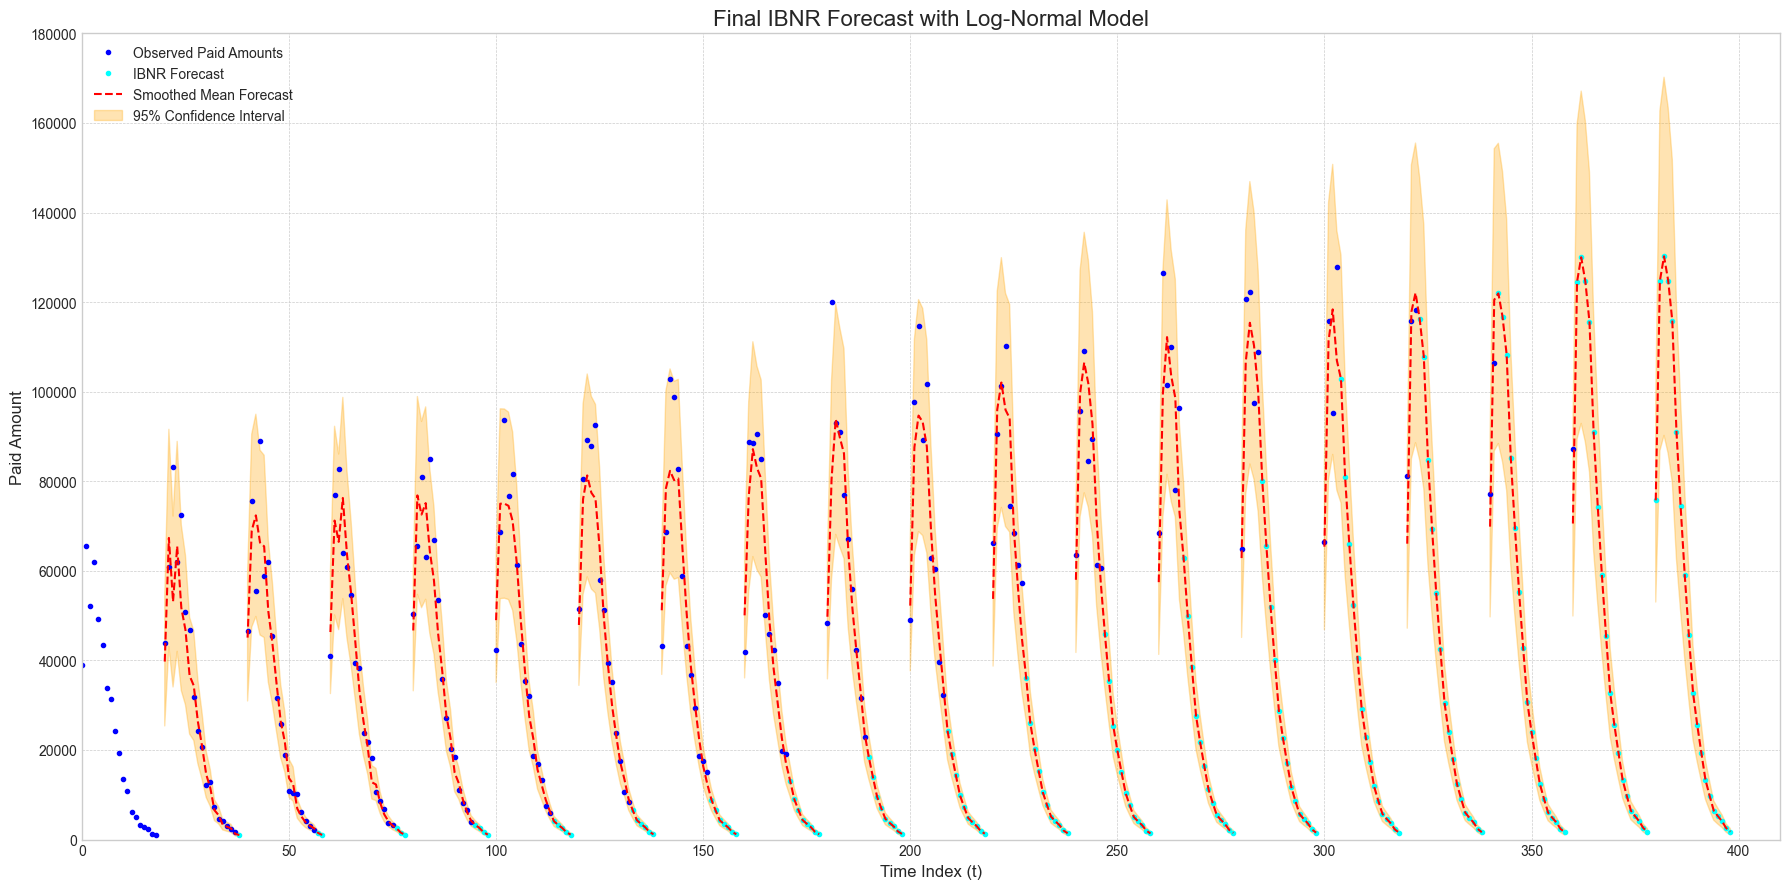

In [10]:


fig, ax = plt.subplots(figsize=(18, 9))

# 1. 과거 관측 데이터 플롯
time_series.dropna().plot(ax=ax, style='.', label='Observed Paid Amounts', color='blue', markersize=6)

# 2. IBNR 예측치 플롯 (미래)
predicted_mean_original[nan_indices].plot(ax=ax, style='.', label='IBNR Forecast', color='cyan', markersize=6)

# 3. 전체 기간에 대한 모델의 평균 추정치(선)
predicted_mean_original.plot(ax=ax, color='red', linestyle='--', linewidth=1.5, label='Smoothed Mean Forecast')

# 4. 95% 신뢰구간 계산 및 플롯
ci_lower = predicted_mean_original - 1.96 * predicted_se_original
ci_upper = predicted_mean_original + 1.96 * predicted_se_original
ax.fill_between(time_series.index, ci_lower, ci_upper, color='orange', alpha=0.3, label='95% Confidence Interval')

# 5. 그래프 스타일링
ax.set_title('Final IBNR Forecast with Log-Normal Model', fontsize=16)
ax.set_xlabel('Time Index (t)', fontsize=12)
ax.set_ylabel('Paid Amount', fontsize=12)
ax.set_xlim(0, 410)
ax.set_ylim(0, 180000)
ax.legend(loc='upper left')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()